## **Automated image classification Model**

Initially analyze the HAM1000 data, then preprocess the images and train the model 


In [1]:
# importing the libraries
import pandas as pd
import os
import glob
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow. keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from pathlib import Path

In [2]:
# read the meta data csv file
data = pd.read_csv('/content/drive/MyDrive/Neural_Computing/HAM10000_metadata.csv')

In [3]:
# Initial analysis of the data, display 5 rows od data
print(data.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


Analyzing individual columns based on its count

In [4]:
print(data['dx'].value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


In [5]:
print(data['sex'].value_counts())

male       5406
female     4552
unknown      57
Name: sex, dtype: int64


In [6]:
print(data['dx_type'].value_counts())

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64


In [7]:
print(data['localization'].value_counts())

back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64


In [8]:
print(data['dataset'].value_counts())

vidir_molemax    3954
vidir_modern     3363
rosendahl        2259
vienna_dias       439
Name: dataset, dtype: int64


Read the training data and extract the contents, add the path of each image based on the image name

............. [[180 179 179 ... 185 187 187]
 [180 180 180 ... 185 186 186]
 [178 178 179 ... 188 188 188]
 ...
 [174 173 175 ... 198 198 198]
 [175 173 174 ... 199 200 201]
 [175 176 175 ... 199 198 198]]
(450, 600)


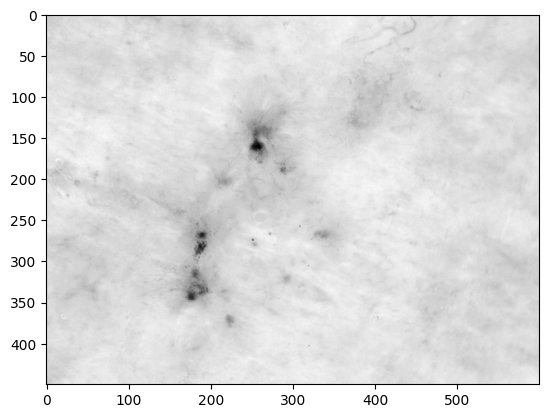

In [9]:
# read the train data and convert into array format
data_dir = "/content/drive/MyDrive/Neural_Computing/input_data/"
  # set the list of image foldersr
categories = ["dataset 1","dataset 2"]
  # analyze the images
for item_ in categories:
  # assigning the location of the images to a variable 
    path = os.path.join(data_dir, item_)  

    # iterate over each images, considering all the age groups
    for img in os.listdir(path):  
      # read one by one image
        # collecting name of the image 
        image_location = path+"/"+img
        # collect the image array
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)  # convert to array
        print('.............',img_array)
        data['path'] = data['image_id'].map(image_location.format)
         # plot the image
        plt.imshow(img_array, cmap='gray')  
        # plt.show()  # displays the last image!
        break  # executing one at a time
    break  #break the for loop 
# checking the array shape
print(img_array.shape) #(128, 128)

Image names are mapped to different groups,so checking list of available columns 

In [10]:
print(data.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset', 'path'],
      dtype='object')


mapping the list of diseases

In [11]:
skin_disease_type = {
    'akiec':'Actinic keratoses and intraepithelial carcinoma',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'akiec': 'Actinic keratoses and intraepithelial carcinoma ',
    'vasc': 'Vascular lesions',
    
}

# mapping the skin diseases and converting it into numeric labels
data['disease_type'] = data['dx'].map(skin_disease_type.get)
data['disease_type_id'] = pd.Categorical(data['disease_type']).codes

checking available data, whether properly the path is added to the variable or not

In [12]:
data.head(6)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,disease_type,disease_type_id
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2


In [13]:
# def preprocess_train_data():
# assigning the path and list of age categories
# set the path of the folder where the images stored
data_dir = "/content/drive/MyDrive/Neural_Computing/input_data/"
# set the list of age categories available in the folder
# categories = ["dataset 1","dataset 2"]
categories = ["dataset 1"]
# set an image size
IMG_SIZE = 64
#initialize new array to keep all the training data
training_data = []

# function to read all the images and extract the training images and corresponding classes
def generate_training_data():
  # iterate through all the age folder and through each image
    for item_ in categories:  
      # access the location to individual images based on the age group
        path = os.path.join(data_dir,item_) 
        # get the list of available classes based each age group 
        class_num = categories.index(item_)  
        
        # iterate over each image per age folder
        for img in (os.listdir(path)):  
            try:
                # read one by one images and convert it into the grayscale format, which is an array
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  
                # resize the image; means it helps to normalize data size
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
                # adding the extracted trained data and corresponding classes to a list
                training_data.append([new_array, img])  
            # skip the errors, if there is any possibility to occur
            except Exception as e:  
                pass

generate_training_data()
#checking the total size of the training data
print(len(training_data))
# print(training_data)

#initialize an empty list to add the list of training features
feature = []
#initialize an empty list to add the list of training targets
image_name = []

# iterating through the set of training features and targets
for features,label in training_data:
    # extracted feature from the training_data will be added to the 'feature' variable
    feature.append(features)
    # extracted target from the training_data will be added to the 'target' variable
    image_name.append(label)

# print(feature)
# print(image_name)

5000


In [14]:
# checking the type of data
print(type(feature))
print(type(image_name))
# print(feature)
# print(image_name)

<class 'list'>
<class 'list'>


Extract name of the image by eliminating the extension

In [15]:
labels = pd.DataFrame(image_name)
labels.columns= ['image_id']
labels['image_id'] = labels['image_id'].str.replace('.jpg', '', regex=False)
print(labels)

          image_id
0     ISIC_0028303
1     ISIC_0028308
2     ISIC_0028299
3     ISIC_0028309
4     ISIC_0028319
...            ...
4995  ISIC_0025310
4996  ISIC_0025313
4997  ISIC_0025302
4998  ISIC_0025308
4999  ISIC_0025303

[5000 rows x 1 columns]


Checking whether the extension is removed from the name of the image or not

In [16]:
data['image_id']

0        ISIC_0027419
1        ISIC_0025030
2        ISIC_0026769
3        ISIC_0025661
4        ISIC_0031633
             ...     
10010    ISIC_0033084
10011    ISIC_0033550
10012    ISIC_0033536
10013    ISIC_0032854
10014    ISIC_0032258
Name: image_id, Length: 10015, dtype: object

combining the data based onthe image_id

In [17]:
print(labels.head(5))
print(len(labels))
print(data.head(5))
print(len(data))


required_data = pd.merge(labels,data, left_on='image_id', right_on='image_id', how='left')
required_data


       image_id
0  ISIC_0028303
1  ISIC_0028308
2  ISIC_0028299
3  ISIC_0028309
4  ISIC_0028319
5000
     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                                               path  \
0  vidir_modern  /content/drive/MyDrive/Neural_Computing/input_...   
1  vidir_modern  /content/drive/MyDrive/Neural_Computing/input_...   
2  vidir_modern  /content/drive/MyDrive/Neural_Computing/input_...   
3  vidir_modern  /content/drive/MyDrive/Neural_Computing/input_...   
4  vidir_modern  /content/drive/MyDrive/Neural_Computing/input_...   

                    disease_type  disease_type_id  
0  Be

,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,path,disease_type,disease_type_id
0,ISIC_0028303,HAM_0005030,bcc,histo,75.0,female,upper extremity,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Basal cell carcinoma,1
1,ISIC_0028308,HAM_0003752,bkl,histo,50.0,female,chest,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
2,ISIC_0028299,HAM_0001540,nv,follow_up,60.0,male,lower extremity,vidir_molemax,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4
3,ISIC_0028309,HAM_0006770,bkl,consensus,70.0,female,back,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
4,ISIC_0028319,HAM_0001464,nv,follow_up,70.0,male,trunk,vidir_molemax,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4
...,...,...,...,...,...,...,...,...,...,...,...
4995,ISIC_0025310,HAM_0005017,nv,histo,75.0,female,back,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4
4996,ISIC_0025313,HAM_0001378,mel,histo,35.0,female,lower extremity,vienna_dias,/content/drive/MyDrive/Neural_Computing/input_...,Melanoma,5
4997,ISIC_0025302,HAM_0007421,df,histo,60.0,female,lower extremity,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Dermatofibroma,3
4998,ISIC_0025308,HAM_0001821,nv,follow_up,40.0,male,trunk,vidir_molemax,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4


In [18]:
#fill the empty age cells with the mean value
required_data['age'].fillna(0, inplace=True)

In [19]:
required_data.head(5)

,image_id,lesion_id,dx,dx_type,age,sex,localization,dataset,path,disease_type,disease_type_id
0,ISIC_0028303,HAM_0005030,bcc,histo,75.0,female,upper extremity,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Basal cell carcinoma,1
1,ISIC_0028308,HAM_0003752,bkl,histo,50.0,female,chest,rosendahl,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
2,ISIC_0028299,HAM_0001540,nv,follow_up,60.0,male,lower extremity,vidir_molemax,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4
3,ISIC_0028309,HAM_0006770,bkl,consensus,70.0,female,back,vidir_modern,/content/drive/MyDrive/Neural_Computing/input_...,Benign keratosis-like lesions,2
4,ISIC_0028319,HAM_0001464,nv,follow_up,70.0,male,trunk,vidir_molemax,/content/drive/MyDrive/Neural_Computing/input_...,Melanocytic nevi,4


Load and train the image data

In [20]:
import cv2

In [21]:
# Function to read and resize images
def load_resize_image(image_path, size):
# def read_and_resize_image(image_path, size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, size)
    return img

In [22]:
image_size = (64, 64)

In [23]:
# Apply the function to each image path in the 'path' column of the dataframe
required_data['image'] = required_data['path'].apply(lambda x: load_resize_image(x, image_size))

In [24]:
required_data['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    5000
Name: image, dtype: int64

In [25]:
# Extract the image data and target labels for train sets
X_train = np.stack(required_data['image'].values)
X_train = X_train/255
y_train = required_data['disease_type_id'].values


In [26]:
y_train

array([1, 2, 4, ..., 3, 4, 5], dtype=int8)

In [27]:
y_train = to_categorical(y_train)

In [28]:
# initializing the model
CNN_model = Sequential()
# adding conv2D layer and parameters, to extract the features
CNN_model.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(image_size[0], image_size[1], 3), activation='relu',))
# adding maxpool2D layer , to extract the improtant features
CNN_model.add(MaxPool2D(pool_size=(2, 2)))   
# adding flatten layer, used to flatten the data
CNN_model.add(Flatten())
# adding dropout layer, to reduce the overfitting 
CNN_model.add(Dropout(0.25))
# adding 1st dense layer,fully connected layer
CNN_model.add(Dense(64, activation='relu'))
# adding 2nd dense layer
CNN_model.add(Dense(32, activation='relu'))
# CNN_model.add(Dense(32, activation='relu'))
# adding final dense layer, gives the final results
CNN_model.add(Dense(len(required_data['disease_type_id'].unique()), activation='softmax')) 
print('CNN Model details \n\n\n')
# display the model summary
CNN_model.summary()
# stops when loss function update become small
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#code to compile the models (model.compile). Use 'categorical cross entropy as the loss function'
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Training Started \n\n\n')

#fitting/training the CNN model, using additional parameter -  callbacks = [early_stop] to enable early stopping.
CNN_model.fit(X_train, y_train, epochs=30, batch_size=10,callbacks = [early_stop], validation_split=0.1)
print('Training Completed \n\n\n')
CNN_model.save('model_v2_.h5')  # creates a HDF5 file '5batch_age_model_v2_.h5'
# losses = pd.DataFrame(CNN_model.history.history)
# return CNN_model

CNN Model details 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dropout (Dropout)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 64)                1843264   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                  

Done